In [1]:
import requests
import datetime
import pandas as pd

# Define the endpoint and parameters
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "inr",
    "days": "30"
}

# Make the request to the CoinGecko API
response = requests.get(url, params=params)
data = response.json()

# Extract the prices, volumes, and market caps
prices = data['prices']
volumes = data['total_volumes']
market_caps = data['market_caps']

# Prepare the data
data_list = []
for i in range(len(prices)):
    timestamp = prices[i][0] / 1000  # Convert milliseconds to seconds
    date = datetime.datetime.fromtimestamp(timestamp).date()
    price_inr = prices[i][1]
    volume = volumes[i][1]
    market_cap = market_caps[i][1]
    data_list.append([date, price_inr, volume, market_cap])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=['Date', 'Price', 'Volume', 'Market Cap'])

# Ensure Date is the index
df.set_index('Date', inplace=True)
print(df)


                   Price        Volume    Market Cap
Date                                                
2024-04-28  5.276340e+06  1.616526e+12  1.039113e+14
2024-04-28  5.279096e+06  1.451043e+12  1.039510e+14
2024-04-28  5.273116e+06  1.560588e+12  1.038127e+14
2024-04-28  5.274755e+06  1.545874e+12  1.038643e+14
2024-04-28  5.274063e+06  1.578235e+12  1.037844e+14
...                  ...           ...           ...
2024-05-27  5.773339e+06  1.226702e+12  1.131165e+14
2024-05-27  5.853944e+06  1.704026e+12  1.151375e+14
2024-05-27  5.824332e+06  1.792615e+12  1.147529e+14
2024-05-27  5.823903e+06  1.825180e+12  1.146961e+14
2024-05-27  5.825336e+06  1.627814e+12  1.149129e+14

[721 rows x 3 columns]


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the dataset for the model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])  # Predicting the price
    return np.array(X), np.array(Y)

# Create the dataset
time_step = 30  # Last 30 days
X, Y = create_dataset(scaled_data, time_step)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=10)





Epoch 1/10

552/552 [==============================] - 16s 18ms/step - loss: 0.0052
Epoch 2/10
552/552 [==============================] - 11s 19ms/step - loss: 0.0020
Epoch 3/10
552/552 [==============================] - 11s 20ms/step - loss: 0.0019
Epoch 4/10
552/552 [==============================] - 11s 21ms/step - loss: 0.0014
Epoch 5/10
552/552 [==============================] - 9s 17ms/step - loss: 0.0014
Epoch 6/10
552/552 [==============================] - 9s 17ms/step - loss: 0.0013
Epoch 7/10
552/552 [==============================] - 10s 18ms/step - loss: 0.0012
Epoch 8/10
552/552 [==============================] - 10s 18ms/step - loss: 0.0011
Epoch 9/10
552/552 [==============================] - 10s 17ms/step - loss: 0.0015
Epoch 10/10
552/552 [==============================] - 11s 19ms/step - loss: 0.0011


5/5 [==============================] - 0s 13ms/step


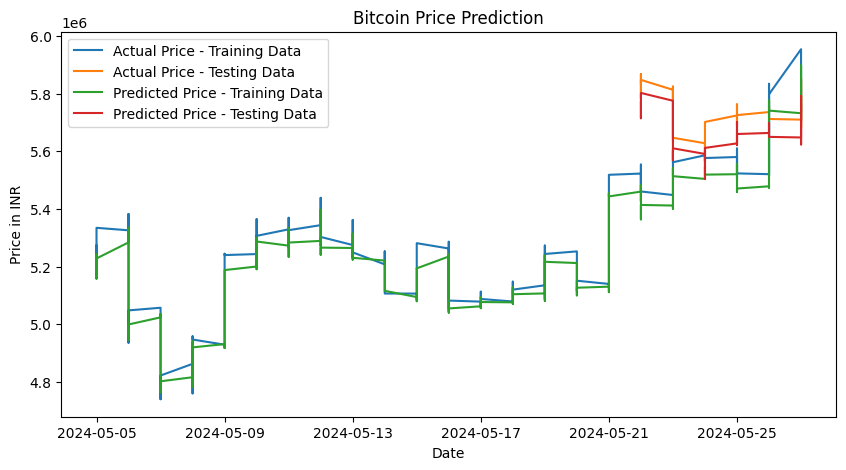

In [4]:
# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(np.concatenate((train_predict, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, X_test[:, -1, 1:]), axis=1))[:, 0]

# Get the actual values
Y_train_actual = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
Y_test_actual = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(Y_train_actual):], Y_train_actual, label='Actual Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], Y_test_actual, label='Actual Price - Testing Data')
plt.plot(df.index[-len(Y_train_actual):], train_predict, label='Predicted Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], test_predict, label='Predicted Price - Testing Data')
plt.xlabel('Date')
plt.ylabel('Price in INR')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()


In [5]:
def predict_future(model, data, days_ahead, time_step):
    temp_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    predictions = []
    for _ in range(days_ahead):
        prediction = model.predict(temp_input)
        predictions.append(prediction[0, 0])
        temp_input = np.append(temp_input[:, 1:, :], [[np.append(prediction, temp_input[:, -1, 1:])]], axis=1)
    return predictions

# Predict the next day, week, and month
next_day_prediction = predict_future(model, scaled_data, 1, time_step)
next_week_prediction = predict_future(model, scaled_data, 7, time_step)
next_month_prediction = predict_future(model, scaled_data, 30, time_step)

# Inverse transform to get actual values
next_day_price = scaler.inverse_transform(np.concatenate((np.array(next_day_prediction).reshape(-1, 1), np.zeros((1, 2))), axis=1))[:, 0]
next_week_price = scaler.inverse_transform(np.concatenate((np.array(next_week_prediction).reshape(-1, 1), np.zeros((7, 2))), axis=1))[:, 0]
next_month_price = scaler.inverse_transform(np.concatenate((np.array(next_month_prediction).reshape(-1, 1), np.zeros((30, 2))), axis=1))[:, 0]

print(f"Next Day Price Prediction: {next_day_price}")
print(f"Next Week Price Predictions: {next_week_price}")
print(f"Next Month Price Predictions: {next_month_price}")


1/1 [==============================] - 0s 40ms/step
Next Day Price Prediction: [5763368.68691038]
Next Week Price Predictions: [5763368.68691038 5723724.70532233 5699735.39588001 5688021.90825191
 5683732.80838327 5683592.58641994 5685496.24962921]
Next Month Price Predictions: [5763368.68691038 5723724.70532233 5699735.39588001 5688021.90825191
 5683732.80838327 5683592.58641994 5685496.24962921 5688118.95718166
 5690671.08369429 5692741.43675683 5694181.33335917 5695010.58826043
 5695340.7137182  5695318.72945989 5695086.59304819 5694761.45743852
 5694428.00541535 5694136.85862608 5693911.73692838 5693757.48553704
 5693666.94510482 5693625.29072066 5693618.20369002 5693631.22068507
 5693654.07274305 5693679.31125011 5693702.45257464 5693722.91818353
 5693738.7555275  5693750.03692321]


In [6]:
# Get the last actual price and the next day predicted price
last_actual_price = df['Price'][-1]
next_day_predicted_price = next_day_price[0]

# Calculate the difference
price_difference = next_day_predicted_price - last_actual_price

# Determine whether to buy or sell based on the difference
if price_difference > 0:
    print("Buy")
elif price_difference < 0:
    print("Sell")
else:
    print("Hold")

Sell


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13636\3906423985.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_actual_price = df['Price'][-1]
